##### Copyright 2019 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

In [2]:
#@title MIT License
#
# Copyright (c) 2017 François Chollet
#
# Permission is hereby granted, free of charge, to any person obtaining a
# copy of this software and associated documentation files (the "Software"),
# to deal in the Software without restriction, including without limitation
# the rights to use, copy, modify, merge, publish, distribute, sublicense,
# and/or sell copies of the Software, and to permit persons to whom the
# Software is furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in
# all copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL
# THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING
# FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER
# DEALINGS IN THE SOFTWARE.

# 映画レビューのテキスト分類

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/tutorials/keras/text_classification"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org で表示</a> </td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab で実行</a> </td>
  <td>     <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub でソースを表示</a> </td>
  <td>     <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/tutorials/keras/text_classification.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a> </td>
</table>

このチュートリアルでは、ディスクに保存されているプレーンテキストファイルを使用してテキストを分類する方法について説明します。IMDB データセットでセンチメント分析を実行するように、二項分類器をトレーニングします。ノートブックの最後には、Stack Overflow のプログラミングに関する質問のタグを予測するためのマルチクラス分類器をトレーニングする演習があります。


In [3]:
import matplotlib.pyplot as plt
import os
import re
import shutil
import string
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import losses


2024-01-11 21:41:17.595673: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 21:41:17.595719: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 21:41:17.597304: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
print(tf.__version__)

2.15.0


## センチメント分析

このノートブックでは、映画レビューのテキストを使用して、それが*肯定的*であるか*否定的*であるかに分類するようにセンチメント分析モデルをトレーニングします。これは*二項*分類の例で、機械学習問題では重要な分類法として広く適用されます。

ここでは、[Internet Movie Database](https://ai.stanford.edu/~amaas/data/sentiment/) から抽出した 50,000 件の映画レビューを含む、[大規模なレビューデータセット](https://www.imdb.com/)を使います。レビューはトレーニング用とテスト用に 25,000 件ずつに分割されています。トレーニング用とテスト用のデータは<strong>均衡</strong>しています。言い換えると、それぞれが同数の肯定的及び否定的なレビューを含んでいます。


### IMDB データセットをダウンロードして調べる

データセットをダウンロードして抽出してから、ディレクトリ構造を調べてみましょう。

In [5]:
url = "https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"

dataset = tf.keras.utils.get_file("aclImdb_v1", url,
                                    untar=True, cache_dir='.',
                                    cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

    8192/84125825 [..............................] - ETA: 0s

   40960/84125825 [..............................] - ETA: 3:17

  106496/84125825 [..............................] - ETA: 2:31

  188416/84125825 [..............................] - ETA: 2:08

  303104/84125825 [..............................] - ETA: 1:44

  385024/84125825 [..............................] - ETA: 1:34

  548864/84125825 [..............................] - ETA: 1:19

  679936/84125825 [..............................] - ETA: 1:10

  892928/84125825 [..............................] - ETA: 1:02

 1056768/84125825 [..............................] - ETA: 56s 

 1335296/84125825 [..............................] - ETA: 50s

 1564672/84125825 [..............................] - ETA: 45s

 1933312/84125825 [..............................] - ETA: 38s

 2236416/84125825 [..............................] - ETA: 36s

 2596864/84125825 [..............................] - ETA: 33s

 3088384/84125825 [>.............................] - ETA: 29s

 3563520/84125825 [>.............................] - ETA: 27s

 4038656/84125825 [>.............................] - ETA: 24s

 4694016/84125825 [>.............................] - ETA: 22s

 5332992/84125825 [>.............................] - ETA: 20s

 5955584/84125825 [=>............................] - ETA: 18s

 6651904/84125825 [=>............................] - ETA: 17s

 7512064/84125825 [=>............................] - ETA: 15s

 8265728/84125825 [=>............................] - ETA: 14s

 9150464/84125825 [==>...........................] - ETA: 13s

10100736/84125825 [==>...........................] - ETA: 12s

11247616/84125825 [===>..........................] - ETA: 11s

12296192/84125825 [===>..........................] - ETA: 10s

13508608/84125825 [===>..........................] - ETA: 10s

14688256/84125825 [====>.........................] - ETA: 9s 

16187392/84125825 [====>.........................] - ETA: 8s

17457152/84125825 [=====>........................] - ETA: 7s

18915328/84125825 [=====>........................] - ETA: 7s

20504576/84125825 [======>.......................] - ETA: 6s

22077440/84125825 [======>.......................] - ETA: 6s

24010752/84125825 [=======>......................] - ETA: 5s

25739264/84125825 [========>.....................] - ETA: 5s

27598848/84125825 [========>.....................] - ETA: 4s

29450240/84125825 [=========>....................] - ETA: 4s

31629312/84125825 [==========>...................] - ETA: 4s

33775616/84125825 [===========>..................] - ETA: 3s

36216832/84125825 [===========>..................] - ETA: 3s

38412288/84125825 [============>.................] - ETA: 3s

40804352/84125825 [=============>................] - ETA: 2s

43483136/84125825 [==============>...............] - ETA: 2s

45981696/84125825 [===============>..............] - ETA: 2s

48996352/84125825 [================>.............] - ETA: 2s

51650560/84125825 [=================>............] - ETA: 1s

54730752/84125825 [==================>...........] - ETA: 1s

58007552/84125825 [===================>..........] - ETA: 1s

61317120/84125825 [====================>.........] - ETA: 1s

64512000/84125825 [======================>.......] - ETA: 0s

67706880/84125825 [=======================>......] - ETA: 0s

70721536/84125825 [========================>.....] - ETA: 0s

73867264/84125825 [=========================>....] - ETA: 0s

76931072/84125825 [==========================>...] - ETA: 0s

80060416/84125825 [===========================>..] - ETA: 0s

83296256/84125825 [============================>.] - ETA: 0s

84125825/84125825 [==============================] - 4s 0us/step


In [6]:
os.listdir(dataset_dir)

['train', 'test', 'imdb.vocab', 'imdbEr.txt', 'README']

In [7]:
train_dir = os.path.join(dataset_dir, 'train')
os.listdir(train_dir)

['neg',
 'pos',
 'unsup',
 'urls_pos.txt',
 'labeledBow.feat',
 'unsupBow.feat',
 'urls_neg.txt',
 'urls_unsup.txt']

`aclImdb/train/pos` および `aclImdb/train/neg` ディレクトリには多くのテキストファイルが含まれており、それぞれが 1 つの映画レビューです。それらの 1 つを見てみましょう。

In [8]:
sample_file = os.path.join(train_dir, 'pos/1181_9.txt')
with open(sample_file) as f:
  print(f.read())

Rachel Griffiths writes and directs this award winning short film. A heartwarming story about coping with grief and cherishing the memory of those we've loved and lost. Although, only 15 minutes long, Griffiths manages to capture so much emotion and truth onto film in the short space of time. Bud Tingwell gives a touching performance as Will, a widower struggling to cope with his wife's death. Will is confronted by the harsh reality of loneliness and helplessness as he proceeds to take care of Ruth's pet cow, Tulip. The film displays the grief and responsibility one feels for those they have loved and lost. Good cinematography, great direction, and superbly acted. It will bring tears to all those who have lost a loved one, and survived.


### データセットを読み込む

次に、データをディスクから読み込み、トレーニングに適した形式に準備します。これを行うには、便利な [text_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text_dataset_from_directory) ユーティリティを使用します。このユーティリティは、次のようなディレクトリ構造を想定しています。

```
main_directory/
...class_a/
......a_text_1.txt
......a_text_2.txt
...class_b/
......b_text_1.txt
......b_text_2.txt
```

二項分類用のデータセットを準備するには、ディスクに `class_a` および `class_b`に対応する 2 つのフォルダが必要です。これらは、`aclImdb/train/pos` および `aclImdb/train/neg` にある肯定的および否定的な映画レビューになります。IMDB データセットには追加のフォルダーが含まれているため、このユーティリティを使用する前にそれらを削除します。

In [9]:
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)

次に、`text_dataset_from_directory` ユーティリティを使用して、ラベル付きの `tf.data.Dataset` を作成します。[tf.data](https://www.tensorflow.org/guide/data) は、データを操作するための強力なツールのコレクションです。

機械学習実験を実行するときは、データセットを[トレーニング](https://developers.google.com/machine-learning/glossary#training_set)、[検証](https://developers.google.com/machine-learning/glossary#validation_set)、および、[テスト](https://developers.google.com/machine-learning/glossary#test-set)の 3 つに分割することをお勧めします。

IMDB データセットはすでにトレーニング用とテスト用に分割されていますが、検証セットはありません。以下の `validation_split` 引数を使用して、トレーニングデータの 80:20 分割を使用して検証セットを作成しましょう。

In [10]:
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='training', 
    seed=seed)

Found 25000 files belonging to 2 classes.


Using 20000 files for training.


上記のように、トレーニングフォルダには 25,000 の例があり、そのうち 80％ (20,000) をトレーニングに使用します。以下に示すとおり、データセットを `model.fit` に直接渡すことで、モデルをトレーニングできます。`tf.data` を初めて使用する場合は、データセットを繰り返し処理して、次のようにいくつかの例を出力することもできます。

In [11]:
for text_batch, label_batch in raw_train_ds.take(1):
  for i in range(3):
    print("Review", text_batch.numpy()[i])
    print("Label", label_batch.numpy()[i])

Review b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label 0
Review b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they get into 

レビューには生のテキストが含まれていることに注意してください（句読点や `<br/>` などのような HTML タグが付いていることもあります）。次のセクションでは、これらの処理方法を示します。

ラベルは 0 または 1 です。これらのどれが肯定的および否定的な映画レビューに対応するかを確認するには、データセットの `class_names` プロパティを確認できます。


In [12]:
print("Label 0 corresponds to", raw_train_ds.class_names[0])
print("Label 1 corresponds to", raw_train_ds.class_names[1])

Label 0 corresponds to neg
Label 1 corresponds to pos


次に、検証およびテスト用データセットを作成します。トレーニング用セットの残りの 5,000 件のレビューを検証に使用します。

注意:  `validation_split` および `subset` 引数を使用する場合は、必ずランダムシードを指定するか、`shuffle=False` を渡して、検証とトレーニング分割に重複がないようにします。

In [13]:
raw_val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train', 
    batch_size=batch_size, 
    validation_split=0.2, 
    subset='validation', 
    seed=seed)

Found 25000 files belonging to 2 classes.


Using 5000 files for validation.


In [14]:
raw_test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test', 
    batch_size=batch_size)

Found 25000 files belonging to 2 classes.


### トレーニング用データセットを準備する

次に、便利な `tf.keras.layers.TextVectorization` レイヤーを使用して、データを標準化、トークン化、およびベクトル化します。

標準化とは、テキストを前処理することを指します。通常、句読点や HTML 要素を削除して、データセットを簡素化します。トークン化とは、文字列をトークンに分割することです (たとえば、空白で分割することにより、文を個々の単語に分割します)。ベクトル化とは、トークンを数値に変換して、ニューラルネットワークに入力できるようにすることです。これらのタスクはすべて、このレイヤーで実行できます。

前述のとおり、レビューには `<br />` のようなさまざまな HTML タグが含まれています。これらのタグは、`TextVectorization` レイヤーのデフォルトの標準化機能によって削除されません (テキストを小文字に変換し、デフォルトで句読点を削除しますが、HTML は削除されません)。HTML を削除するカスタム標準化関数を作成します。

注意: [トレーニング/テストスキュー](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)（トレーニング/サービングスキューとも呼ばれます）を防ぐには、トレーニング時とテスト時にデータを同じように前処理することが重要です。これを容易にするためには、このチュートリアルの後半で示すように、`TextVectorization` レイヤーをモデル内に直接含めます。

In [15]:
def custom_standardization(input_data):
  lowercase = tf.strings.lower(input_data)
  stripped_html = tf.strings.regex_replace(lowercase, '<br />', ' ')
  return tf.strings.regex_replace(stripped_html,
                                  '[%s]' % re.escape(string.punctuation),
                                  '')

次に、`TextVectorization` レイヤーを作成します。このレイヤーを使用して、データを標準化、トークン化、およびベクトル化します。`output_mode` を `int` に設定して、トークンごとに一意の整数インデックスを作成します。

デフォルトの分割関数と、上記で定義したカスタム標準化関数を使用していることに注意してください。また、明示的な最大値 `sequence_length` など、モデルの定数をいくつか定義します。これにより、レイヤーはシーケンスを正確に `sequence_length` 値にパディングまたは切り捨てます。

In [16]:
max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=custom_standardization,
    max_tokens=max_features,
    output_mode='int',
    output_sequence_length=sequence_length)

次に、`adapt` を呼び出して、前処理レイヤーの状態をデータセットに適合させます。これにより、モデルは文字列から整数へのインデックスを作成します。

注意: Adapt を呼び出すときは、トレーニング用データのみを使用することが重要です（テスト用セットを使用すると情報が漏洩します）。

In [17]:
# Make a text-only dataset (without labels), then call adapt
train_text = raw_train_ds.map(lambda x, y: x)
vectorize_layer.adapt(train_text)

このレイヤーを使用して一部のデータを前処理した結果を確認する関数を作成します。

In [18]:
def vectorize_text(text, label):
  text = tf.expand_dims(text, -1)
  return vectorize_layer(text), label

In [19]:
# retrieve a batch (of 32 reviews and labels) from the dataset
text_batch, label_batch = next(iter(raw_train_ds))
first_review, first_label = text_batch[0], label_batch[0]
print("Review", first_review)
print("Label", raw_train_ds.class_names[first_label])
print("Vectorized review", vectorize_text(first_review, first_label))

Review tf.Tensor(b'Great movie - especially the music - Etta James - "At Last". This speaks volumes when you have finally found that special someone.', shape=(), dtype=string)
Label neg
Vectorized review (<tf.Tensor: shape=(1, 250), dtype=int64, numpy=
array([[  86,   17,  260,    2,  222,    1,  571,   31,  229,   11, 2418,
           1,   51,   22,   25,  404,  251,   12,  306,  282,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
       

上記のように、各トークンは整数に置き換えられています。レイヤーで `.get_vocabulary()` を呼び出すことにより、各整数が対応するトークン（文字列）を検索できます。

In [20]:
print("1287 ---> ",vectorize_layer.get_vocabulary()[1287])
print(" 313 ---> ",vectorize_layer.get_vocabulary()[313])
print('Vocabulary size: {}'.format(len(vectorize_layer.get_vocabulary())))

1287 --->  silent
 313 --->  night
Vocabulary size: 10000


モデルをトレーニングする準備がほぼ整いました。最後の前処理ステップとして、トレーニング、検証、およびデータセットのテストのために前に作成した TextVectorization レイヤーを適用します。

In [21]:
train_ds = raw_train_ds.map(vectorize_text)
val_ds = raw_val_ds.map(vectorize_text)
test_ds = raw_test_ds.map(vectorize_text)

### データセットを構成してパフォーマンスを改善する

以下は、I/O がブロックされないようにするためにデータを読み込むときに使用する必要がある 2 つの重要な方法です。

`.cache()` はデータをディスクから読み込んだ後、データをメモリに保持します。これにより、モデルのトレーニング中にデータセットがボトルネックになることを回避できます。データセットが大きすぎてメモリに収まらない場合は、この方法を使用して、パフォーマンスの高いオンディスクキャッシュを作成することもできます。これは、多くの小さなファイルを読み込むより効率的です。

`.prefetch()` はトレーニング中にデータの前処理とモデルの実行をオーバーラップさせます。

以上の 2 つの方法とデータをディスクにキャッシュする方法についての詳細は、[データパフォーマンスガイド](https://www.tensorflow.org/guide/data_performance)を参照してください。

In [22]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

### モデルを作成する

ニューラルネットワークを作成します。

In [23]:
embedding_dim = 16

In [24]:
model = tf.keras.Sequential([
  layers.Embedding(max_features + 1, embedding_dim),
  layers.Dropout(0.2),
  layers.GlobalAveragePooling1D(),
  layers.Dropout(0.2),
  layers.Dense(1)])

model.summary()

Model: "sequential"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 embedding (Embedding)       (None, None, 16)          160016    


 dropout (Dropout)           (None, None, 16)          0         


 global_average_pooling1d (  (None, 16)                0         


 GlobalAveragePooling1D)                                         


 dropout_1 (Dropout)         (None, 16)                0         


 dense (Dense)               (None, 1)                 17        


Total params: 160033 (625.13 KB)


Trainable params: 160033 (625.13 KB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


これらのレイヤーは、分類器を構成するため一列に積み重ねられます。

1. 最初のレイヤーは `Embedding` （埋め込み）レイヤーです。このレイヤーは、整数にエンコードされた語彙を受け取り、それぞれの単語インデックスに対応する埋め込みベクトルを検索します。埋め込みベクトルは、モデルのトレーニングの中で学習されます。ベクトル化のために、出力行列には次元が１つ追加されます。その結果、次元は、`(batch, sequence, embedding)` となります。埋め込みの詳細については、[単語埋め込みチュートリアル](https://www.tensorflow.org/text/guide/word_embeddings)を参照してください。
2. 次は、`GlobalAveragePooling1D`（１次元のグローバル平均プーリング）レイヤーです。このレイヤーは、それぞれのサンプルについて、シーケンスの次元方向に平均値をもとめ、固定長のベクトルを返します。この結果、モデルは最も単純な形で、可変長の入力を扱うことができるようになります。
3. 最後のレイヤーは、単一の出力ノードと密に接続されています。

### 損失関数とオプティマイザ

モデルをトレーニングするには、損失関数とオプティマイザが必要です。これは二項分類問題であり、モデルは確率（シグモイドアクティベーションを持つ単一ユニットレイヤー）を出力するため、`losses.BinaryCrossentropy` 損失関数を使用します。

損失関数の候補はこれだけではありません。例えば、`mean_squared_error`（平均二乗誤差）を使うこともできます。しかし、一般的には、確率を扱うには`binary_crossentropy`の方が適しています。`binary_crossentropy`は、確率分布の間の「距離」を測定する尺度です。今回の場合には、真の分布と予測値の分布の間の距離ということになります。

In [25]:
model.compile(loss=losses.BinaryCrossentropy(from_logits=True),
              optimizer='adam',
              metrics=tf.metrics.BinaryAccuracy(threshold=0.0))

### モデルをトレーニングする

`dataset` オブジェクトを fit メソッドに渡すことにより、モデルをトレーニングします。

In [26]:
epochs = 10
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs)

Epoch 1/10


I0000 00:00:1705009314.868632  943769 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


  1/625 [..............................] - ETA: 21:58 - loss: 0.6933 - binary_accuracy: 0.5000

  2/625 [..............................] - ETA: 1:33 - loss: 0.6937 - binary_accuracy: 0.4844 

  3/625 [..............................] - ETA: 1:33 - loss: 0.6942 - binary_accuracy: 0.4896

  4/625 [..............................] - ETA: 1:33 - loss: 0.6942 - binary_accuracy: 0.4844

  5/625 [..............................] - ETA: 1:33 - loss: 0.6945 - binary_accuracy: 0.4563

  6/625 [..............................] - ETA: 1:33 - loss: 0.6947 - binary_accuracy: 0.4427

  7/625 [..............................] - ETA: 1:32 - loss: 0.6942 - binary_accuracy: 0.4598

  8/625 [..............................] - ETA: 1:32 - loss: 0.6939 - binary_accuracy: 0.4805

  9/625 [..............................] - ETA: 1:32 - loss: 0.6938 - binary_accuracy: 0.4722

 10/625 [..............................] - ETA: 1:32 - loss: 0.6935 - binary_accuracy: 0.4906

 11/625 [..............................] - ETA: 1:32 - loss: 0.6934 - binary_accuracy: 0.5000

 12/625 [..............................] - ETA: 1:32 - loss: 0.6932 - binary_accuracy: 0.5078

 13/625 [..............................] - ETA: 1:32 - loss: 0.6932 - binary_accuracy: 0.5120

 14/625 [..............................] - ETA: 1:32 - loss: 0.6929 - binary_accuracy: 0.5246

 15/625 [..............................] - ETA: 1:31 - loss: 0.6929 - binary_accuracy: 0.5250

 16/625 [..............................] - ETA: 1:31 - loss: 0.6930 - binary_accuracy: 0.5195

 17/625 [..............................] - ETA: 1:31 - loss: 0.6929 - binary_accuracy: 0.5221

 18/625 [..............................] - ETA: 1:31 - loss: 0.6929 - binary_accuracy: 0.5208

 19/625 [..............................] - ETA: 1:31 - loss: 0.6928 - binary_accuracy: 0.5247

 21/625 [>.............................] - ETA: 1:26 - loss: 0.6929 - binary_accuracy: 0.5179

 22/625 [>.............................] - ETA: 1:26 - loss: 0.6927 - binary_accuracy: 0.5284

 23/625 [>.............................] - ETA: 1:26 - loss: 0.6926 - binary_accuracy: 0.5367

 24/625 [>.............................] - ETA: 1:26 - loss: 0.6925 - binary_accuracy: 0.5430

 25/625 [>.............................] - ETA: 1:26 - loss: 0.6925 - binary_accuracy: 0.5400

 26/625 [>.............................] - ETA: 1:26 - loss: 0.6924 - binary_accuracy: 0.5409

 27/625 [>.............................] - ETA: 1:26 - loss: 0.6923 - binary_accuracy: 0.5405

 28/625 [>.............................] - ETA: 1:26 - loss: 0.6923 - binary_accuracy: 0.5413

 29/625 [>.............................] - ETA: 1:26 - loss: 0.6923 - binary_accuracy: 0.5409

 30/625 [>.............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5427

 31/625 [>.............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5403

 32/625 [>.............................] - ETA: 1:26 - loss: 0.6921 - binary_accuracy: 0.5381

 33/625 [>.............................] - ETA: 1:26 - loss: 0.6922 - binary_accuracy: 0.5369

 35/625 [>.............................] - ETA: 1:23 - loss: 0.6922 - binary_accuracy: 0.5339

 36/625 [>.............................] - ETA: 1:23 - loss: 0.6922 - binary_accuracy: 0.5347

 37/625 [>.............................] - ETA: 1:23 - loss: 0.6922 - binary_accuracy: 0.5363

 38/625 [>.............................] - ETA: 1:23 - loss: 0.6922 - binary_accuracy: 0.5312

 39/625 [>.............................] - ETA: 1:23 - loss: 0.6923 - binary_accuracy: 0.5304

 40/625 [>.............................] - ETA: 1:23 - loss: 0.6923 - binary_accuracy: 0.5297

 41/625 [>.............................] - ETA: 1:23 - loss: 0.6922 - binary_accuracy: 0.5305

 42/625 [=>............................] - ETA: 1:23 - loss: 0.6922 - binary_accuracy: 0.5320

 43/625 [=>............................] - ETA: 1:23 - loss: 0.6922 - binary_accuracy: 0.5298

 44/625 [=>............................] - ETA: 1:23 - loss: 0.6922 - binary_accuracy: 0.5312

 46/625 [=>............................] - ETA: 1:21 - loss: 0.6920 - binary_accuracy: 0.5360

 47/625 [=>............................] - ETA: 1:21 - loss: 0.6920 - binary_accuracy: 0.5386

 48/625 [=>............................] - ETA: 1:21 - loss: 0.6919 - binary_accuracy: 0.5417

 49/625 [=>............................] - ETA: 1:21 - loss: 0.6919 - binary_accuracy: 0.5459

 50/625 [=>............................] - ETA: 1:21 - loss: 0.6918 - binary_accuracy: 0.5481

 51/625 [=>............................] - ETA: 1:21 - loss: 0.6918 - binary_accuracy: 0.5521

 52/625 [=>............................] - ETA: 1:21 - loss: 0.6917 - binary_accuracy: 0.5565

 54/625 [=>............................] - ETA: 1:19 - loss: 0.6916 - binary_accuracy: 0.5590

 55/625 [=>............................] - ETA: 1:19 - loss: 0.6916 - binary_accuracy: 0.5608

 56/625 [=>............................] - ETA: 1:19 - loss: 0.6916 - binary_accuracy: 0.5603

 57/625 [=>............................] - ETA: 1:19 - loss: 0.6916 - binary_accuracy: 0.5592

 58/625 [=>............................] - ETA: 1:19 - loss: 0.6916 - binary_accuracy: 0.5593

 59/625 [=>............................] - ETA: 1:19 - loss: 0.6916 - binary_accuracy: 0.5577

 60/625 [=>............................] - ETA: 1:19 - loss: 0.6915 - binary_accuracy: 0.5583

 61/625 [=>............................] - ETA: 1:19 - loss: 0.6914 - binary_accuracy: 0.5589

 62/625 [=>............................] - ETA: 1:19 - loss: 0.6913 - binary_accuracy: 0.5605

 63/625 [==>...........................] - ETA: 1:19 - loss: 0.6913 - binary_accuracy: 0.5605

 64/625 [==>...........................] - ETA: 1:19 - loss: 0.6912 - binary_accuracy: 0.5596

 65/625 [==>...........................] - ETA: 1:19 - loss: 0.6911 - binary_accuracy: 0.5601

 68/625 [==>...........................] - ETA: 1:16 - loss: 0.6912 - binary_accuracy: 0.5565

 70/625 [==>...........................] - ETA: 1:15 - loss: 0.6912 - binary_accuracy: 0.5549

 71/625 [==>...........................] - ETA: 1:15 - loss: 0.6911 - binary_accuracy: 0.5546

 73/625 [==>...........................] - ETA: 1:14 - loss: 0.6911 - binary_accuracy: 0.5535

 74/625 [==>...........................] - ETA: 1:14 - loss: 0.6910 - binary_accuracy: 0.5541

 76/625 [==>...........................] - ETA: 1:13 - loss: 0.6908 - binary_accuracy: 0.5563

 77/625 [==>...........................] - ETA: 1:13 - loss: 0.6908 - binary_accuracy: 0.5552

 78/625 [==>...........................] - ETA: 1:13 - loss: 0.6908 - binary_accuracy: 0.5525

 79/625 [==>...........................] - ETA: 1:13 - loss: 0.6907 - binary_accuracy: 0.5534

 80/625 [==>...........................] - ETA: 1:13 - loss: 0.6906 - binary_accuracy: 0.5535

 83/625 [==>...........................] - ETA: 1:11 - loss: 0.6906 - binary_accuracy: 0.5505

 84/625 [===>..........................] - ETA: 1:11 - loss: 0.6906 - binary_accuracy: 0.5506

 85/625 [===>..........................] - ETA: 1:11 - loss: 0.6906 - binary_accuracy: 0.5496

 86/625 [===>..........................] - ETA: 1:11 - loss: 0.6905 - binary_accuracy: 0.5505

 88/625 [===>..........................] - ETA: 1:10 - loss: 0.6904 - binary_accuracy: 0.5501

 89/625 [===>..........................] - ETA: 1:10 - loss: 0.6905 - binary_accuracy: 0.5478

 90/625 [===>..........................] - ETA: 1:10 - loss: 0.6905 - binary_accuracy: 0.5472

 91/625 [===>..........................] - ETA: 1:10 - loss: 0.6904 - binary_accuracy: 0.5470

 93/625 [===>..........................] - ETA: 1:09 - loss: 0.6904 - binary_accuracy: 0.5450

 96/625 [===>..........................] - ETA: 1:07 - loss: 0.6905 - binary_accuracy: 0.5430

 98/625 [===>..........................] - ETA: 1:06 - loss: 0.6903 - binary_accuracy: 0.5437

101/625 [===>..........................] - ETA: 1:05 - loss: 0.6904 - binary_accuracy: 0.5408

102/625 [===>..........................] - ETA: 1:05 - loss: 0.6904 - binary_accuracy: 0.5398

104/625 [===>..........................] - ETA: 1:04 - loss: 0.6903 - binary_accuracy: 0.5400

105/625 [====>.........................] - ETA: 1:04 - loss: 0.6903 - binary_accuracy: 0.5405

107/625 [====>.........................] - ETA: 1:03 - loss: 0.6902 - binary_accuracy: 0.5394

108/625 [====>.........................] - ETA: 1:03 - loss: 0.6902 - binary_accuracy: 0.5405

109/625 [====>.........................] - ETA: 1:03 - loss: 0.6901 - binary_accuracy: 0.5421

110/625 [====>.........................] - ETA: 1:03 - loss: 0.6901 - binary_accuracy: 0.5429

111/625 [====>.........................] - ETA: 1:03 - loss: 0.6901 - binary_accuracy: 0.5419

112/625 [====>.........................] - ETA: 1:03 - loss: 0.6901 - binary_accuracy: 0.5421

113/625 [====>.........................] - ETA: 1:03 - loss: 0.6901 - binary_accuracy: 0.5423

115/625 [====>.........................] - ETA: 1:03 - loss: 0.6900 - binary_accuracy: 0.5440

117/625 [====>.........................] - ETA: 1:02 - loss: 0.6900 - binary_accuracy: 0.5454

119/625 [====>.........................] - ETA: 1:01 - loss: 0.6900 - binary_accuracy: 0.5470

120/625 [====>.........................] - ETA: 1:01 - loss: 0.6900 - binary_accuracy: 0.5484

121/625 [====>.........................] - ETA: 1:01 - loss: 0.6899 - binary_accuracy: 0.5504

122/625 [====>.........................] - ETA: 1:01 - loss: 0.6898 - binary_accuracy: 0.5528

124/625 [====>.........................] - ETA: 1:01 - loss: 0.6898 - binary_accuracy: 0.5547

125/625 [=====>........................] - ETA: 1:01 - loss: 0.6898 - binary_accuracy: 0.5550

127/625 [=====>........................] - ETA: 1:00 - loss: 0.6897 - binary_accuracy: 0.5566

130/625 [=====>........................] - ETA: 59s - loss: 0.6897 - binary_accuracy: 0.5577 

131/625 [=====>........................] - ETA: 59s - loss: 0.6896 - binary_accuracy: 0.5592

134/625 [=====>........................] - ETA: 58s - loss: 0.6895 - binary_accuracy: 0.5630

136/625 [=====>........................] - ETA: 57s - loss: 0.6894 - binary_accuracy: 0.5655

137/625 [=====>........................] - ETA: 57s - loss: 0.6894 - binary_accuracy: 0.5673

139/625 [=====>........................] - ETA: 57s - loss: 0.6893 - binary_accuracy: 0.5699

142/625 [=====>........................] - ETA: 56s - loss: 0.6892 - binary_accuracy: 0.5722

144/625 [=====>........................] - ETA: 55s - loss: 0.6892 - binary_accuracy: 0.5749

145/625 [=====>........................] - ETA: 55s - loss: 0.6892 - binary_accuracy: 0.5754

146/625 [======>.......................] - ETA: 55s - loss: 0.6891 - binary_accuracy: 0.5771

147/625 [======>.......................] - ETA: 55s - loss: 0.6891 - binary_accuracy: 0.5772

148/625 [======>.......................] - ETA: 55s - loss: 0.6891 - binary_accuracy: 0.5781

149/625 [======>.......................] - ETA: 55s - loss: 0.6891 - binary_accuracy: 0.5789

151/625 [======>.......................] - ETA: 55s - loss: 0.6890 - binary_accuracy: 0.5815

152/625 [======>.......................] - ETA: 55s - loss: 0.6889 - binary_accuracy: 0.5829

160/625 [======>.......................] - ETA: 52s - loss: 0.6887 - binary_accuracy: 0.5887

162/625 [======>.......................] - ETA: 51s - loss: 0.6886 - binary_accuracy: 0.5907

164/625 [======>.......................] - ETA: 51s - loss: 0.6886 - binary_accuracy: 0.5926

165/625 [======>.......................] - ETA: 51s - loss: 0.6885 - binary_accuracy: 0.5928

166/625 [======>.......................] - ETA: 51s - loss: 0.6884 - binary_accuracy: 0.5943

167/625 [=======>......................] - ETA: 51s - loss: 0.6884 - binary_accuracy: 0.5954

169/625 [=======>......................] - ETA: 50s - loss: 0.6883 - binary_accuracy: 0.5967

170/625 [=======>......................] - ETA: 50s - loss: 0.6883 - binary_accuracy: 0.5980

171/625 [=======>......................] - ETA: 50s - loss: 0.6882 - binary_accuracy: 0.5983

172/625 [=======>......................] - ETA: 50s - loss: 0.6882 - binary_accuracy: 0.5988

174/625 [=======>......................] - ETA: 50s - loss: 0.6881 - binary_accuracy: 0.6004

175/625 [=======>......................] - ETA: 50s - loss: 0.6881 - binary_accuracy: 0.6011

179/625 [=======>......................] - ETA: 49s - loss: 0.6879 - binary_accuracy: 0.6030

180/625 [=======>......................] - ETA: 49s - loss: 0.6879 - binary_accuracy: 0.6024

181/625 [=======>......................] - ETA: 49s - loss: 0.6879 - binary_accuracy: 0.6026

183/625 [=======>......................] - ETA: 48s - loss: 0.6878 - binary_accuracy: 0.6040

185/625 [=======>......................] - ETA: 48s - loss: 0.6878 - binary_accuracy: 0.6034

188/625 [========>.....................] - ETA: 47s - loss: 0.6877 - binary_accuracy: 0.6031

189/625 [========>.....................] - ETA: 47s - loss: 0.6876 - binary_accuracy: 0.6040

190/625 [========>.....................] - ETA: 47s - loss: 0.6875 - binary_accuracy: 0.6041

191/625 [========>.....................] - ETA: 47s - loss: 0.6875 - binary_accuracy: 0.6047

192/625 [========>.....................] - ETA: 47s - loss: 0.6875 - binary_accuracy: 0.6040

194/625 [========>.....................] - ETA: 47s - loss: 0.6874 - binary_accuracy: 0.6037

195/625 [========>.....................] - ETA: 47s - loss: 0.6874 - binary_accuracy: 0.6042

196/625 [========>.....................] - ETA: 47s - loss: 0.6874 - binary_accuracy: 0.6040

197/625 [========>.....................] - ETA: 47s - loss: 0.6874 - binary_accuracy: 0.6036

201/625 [========>.....................] - ETA: 46s - loss: 0.6873 - binary_accuracy: 0.6037

202/625 [========>.....................] - ETA: 46s - loss: 0.6873 - binary_accuracy: 0.6038

204/625 [========>.....................] - ETA: 45s - loss: 0.6872 - binary_accuracy: 0.6036

206/625 [========>.....................] - ETA: 45s - loss: 0.6872 - binary_accuracy: 0.6038

207/625 [========>.....................] - ETA: 45s - loss: 0.6871 - binary_accuracy: 0.6046

211/625 [=========>....................] - ETA: 44s - loss: 0.6869 - binary_accuracy: 0.6071

213/625 [=========>....................] - ETA: 44s - loss: 0.6869 - binary_accuracy: 0.6077

214/625 [=========>....................] - ETA: 44s - loss: 0.6868 - binary_accuracy: 0.6084

215/625 [=========>....................] - ETA: 44s - loss: 0.6867 - binary_accuracy: 0.6090

217/625 [=========>....................] - ETA: 43s - loss: 0.6866 - binary_accuracy: 0.6103

218/625 [=========>....................] - ETA: 43s - loss: 0.6866 - binary_accuracy: 0.6105

219/625 [=========>....................] - ETA: 43s - loss: 0.6866 - binary_accuracy: 0.6112

220/625 [=========>....................] - ETA: 43s - loss: 0.6865 - binary_accuracy: 0.6111

221/625 [=========>....................] - ETA: 43s - loss: 0.6865 - binary_accuracy: 0.6116

224/625 [=========>....................] - ETA: 43s - loss: 0.6864 - binary_accuracy: 0.6133

225/625 [=========>....................] - ETA: 43s - loss: 0.6863 - binary_accuracy: 0.6142

226/625 [=========>....................] - ETA: 43s - loss: 0.6862 - binary_accuracy: 0.6149

228/625 [=========>....................] - ETA: 42s - loss: 0.6861 - binary_accuracy: 0.6158

233/625 [==========>...................] - ETA: 41s - loss: 0.6860 - binary_accuracy: 0.6188

235/625 [==========>...................] - ETA: 41s - loss: 0.6859 - binary_accuracy: 0.6201

237/625 [==========>...................] - ETA: 41s - loss: 0.6858 - binary_accuracy: 0.6200

238/625 [==========>...................] - ETA: 41s - loss: 0.6857 - binary_accuracy: 0.6209

240/625 [==========>...................] - ETA: 40s - loss: 0.6856 - binary_accuracy: 0.6220

241/625 [==========>...................] - ETA: 40s - loss: 0.6856 - binary_accuracy: 0.6224

244/625 [==========>...................] - ETA: 40s - loss: 0.6854 - binary_accuracy: 0.6244

245/625 [==========>...................] - ETA: 40s - loss: 0.6854 - binary_accuracy: 0.6247

247/625 [==========>...................] - ETA: 39s - loss: 0.6853 - binary_accuracy: 0.6258

249/625 [==========>...................] - ETA: 39s - loss: 0.6852 - binary_accuracy: 0.6270

251/625 [===========>..................] - ETA: 39s - loss: 0.6851 - binary_accuracy: 0.6280

253/625 [===========>..................] - ETA: 38s - loss: 0.6850 - binary_accuracy: 0.6286

254/625 [===========>..................] - ETA: 38s - loss: 0.6849 - binary_accuracy: 0.6289

256/625 [===========>..................] - ETA: 38s - loss: 0.6848 - binary_accuracy: 0.6299

258/625 [===========>..................] - ETA: 38s - loss: 0.6847 - binary_accuracy: 0.6309

259/625 [===========>..................] - ETA: 38s - loss: 0.6847 - binary_accuracy: 0.6316

261/625 [===========>..................] - ETA: 38s - loss: 0.6845 - binary_accuracy: 0.6328

262/625 [===========>..................] - ETA: 37s - loss: 0.6845 - binary_accuracy: 0.6336

264/625 [===========>..................] - ETA: 37s - loss: 0.6843 - binary_accuracy: 0.6341

266/625 [===========>..................] - ETA: 37s - loss: 0.6842 - binary_accuracy: 0.6344

267/625 [===========>..................] - ETA: 37s - loss: 0.6842 - binary_accuracy: 0.6347

268/625 [===========>..................] - ETA: 37s - loss: 0.6841 - binary_accuracy: 0.6348

269/625 [===========>..................] - ETA: 37s - loss: 0.6841 - binary_accuracy: 0.6355

270/625 [===========>..................] - ETA: 37s - loss: 0.6841 - binary_accuracy: 0.6358

271/625 [============>.................] - ETA: 37s - loss: 0.6840 - binary_accuracy: 0.6364

275/625 [============>.................] - ETA: 36s - loss: 0.6838 - binary_accuracy: 0.6382

277/625 [============>.................] - ETA: 36s - loss: 0.6838 - binary_accuracy: 0.6382

280/625 [============>.................] - ETA: 35s - loss: 0.6836 - binary_accuracy: 0.6397

281/625 [============>.................] - ETA: 35s - loss: 0.6835 - binary_accuracy: 0.6399

284/625 [============>.................] - ETA: 35s - loss: 0.6833 - binary_accuracy: 0.6411

288/625 [============>.................] - ETA: 34s - loss: 0.6832 - binary_accuracy: 0.6423

291/625 [============>.................] - ETA: 33s - loss: 0.6831 - binary_accuracy: 0.6424

293/625 [=============>................] - ETA: 33s - loss: 0.6830 - binary_accuracy: 0.6427

301/625 [=============>................] - ETA: 32s - loss: 0.6826 - binary_accuracy: 0.6450

302/625 [=============>................] - ETA: 32s - loss: 0.6825 - binary_accuracy: 0.6454

306/625 [=============>................] - ETA: 31s - loss: 0.6824 - binary_accuracy: 0.6460

307/625 [=============>................] - ETA: 31s - loss: 0.6823 - binary_accuracy: 0.6467

308/625 [=============>................] - ETA: 31s - loss: 0.6822 - binary_accuracy: 0.6472

311/625 [=============>................] - ETA: 30s - loss: 0.6820 - binary_accuracy: 0.6476

315/625 [==============>...............] - ETA: 30s - loss: 0.6819 - binary_accuracy: 0.6476

321/625 [==============>...............] - ETA: 29s - loss: 0.6817 - binary_accuracy: 0.6481

327/625 [==============>...............] - ETA: 28s - loss: 0.6814 - binary_accuracy: 0.6498

329/625 [==============>...............] - ETA: 28s - loss: 0.6813 - binary_accuracy: 0.6502

330/625 [==============>...............] - ETA: 28s - loss: 0.6812 - binary_accuracy: 0.6506

333/625 [==============>...............] - ETA: 27s - loss: 0.6810 - binary_accuracy: 0.6514

338/625 [===============>..............] - ETA: 27s - loss: 0.6808 - binary_accuracy: 0.6522

339/625 [===============>..............] - ETA: 26s - loss: 0.6807 - binary_accuracy: 0.6527

343/625 [===============>..............] - ETA: 26s - loss: 0.6805 - binary_accuracy: 0.6537

348/625 [===============>..............] - ETA: 25s - loss: 0.6803 - binary_accuracy: 0.6540

349/625 [===============>..............] - ETA: 25s - loss: 0.6802 - binary_accuracy: 0.6541

354/625 [===============>..............] - ETA: 24s - loss: 0.6801 - binary_accuracy: 0.6547

360/625 [================>.............] - ETA: 24s - loss: 0.6797 - binary_accuracy: 0.6564

369/625 [================>.............] - ETA: 22s - loss: 0.6791 - binary_accuracy: 0.6588

370/625 [================>.............] - ETA: 22s - loss: 0.6791 - binary_accuracy: 0.6587

374/625 [================>.............] - ETA: 22s - loss: 0.6789 - binary_accuracy: 0.6600

378/625 [=================>............] - ETA: 21s - loss: 0.6786 - binary_accuracy: 0.6612

380/625 [=================>............] - ETA: 21s - loss: 0.6785 - binary_accuracy: 0.6624

390/625 [=================>............] - ETA: 20s - loss: 0.6778 - binary_accuracy: 0.6653

391/625 [=================>............] - ETA: 20s - loss: 0.6777 - binary_accuracy: 0.6659

392/625 [=================>............] - ETA: 20s - loss: 0.6776 - binary_accuracy: 0.6662

394/625 [=================>............] - ETA: 20s - loss: 0.6774 - binary_accuracy: 0.6670

401/625 [==================>...........] - ETA: 19s - loss: 0.6770 - binary_accuracy: 0.6680

403/625 [==================>...........] - ETA: 19s - loss: 0.6769 - binary_accuracy: 0.6686

407/625 [==================>...........] - ETA: 18s - loss: 0.6765 - binary_accuracy: 0.6696

409/625 [==================>...........] - ETA: 18s - loss: 0.6764 - binary_accuracy: 0.6702

410/625 [==================>...........] - ETA: 18s - loss: 0.6763 - binary_accuracy: 0.6707

418/625 [===================>..........] - ETA: 17s - loss: 0.6758 - binary_accuracy: 0.6720

421/625 [===================>..........] - ETA: 17s - loss: 0.6755 - binary_accuracy: 0.6725

427/625 [===================>..........] - ETA: 16s - loss: 0.6751 - binary_accuracy: 0.6740

437/625 [===================>..........] - ETA: 15s - loss: 0.6746 - binary_accuracy: 0.6752

445/625 [====================>.........] - ETA: 14s - loss: 0.6740 - binary_accuracy: 0.6771

446/625 [====================>.........] - ETA: 14s - loss: 0.6739 - binary_accuracy: 0.6774

447/625 [====================>.........] - ETA: 14s - loss: 0.6739 - binary_accuracy: 0.6774

451/625 [====================>.........] - ETA: 14s - loss: 0.6736 - binary_accuracy: 0.6781

454/625 [====================>.........] - ETA: 13s - loss: 0.6734 - binary_accuracy: 0.6788

456/625 [====================>.........] - ETA: 13s - loss: 0.6733 - binary_accuracy: 0.6793

464/625 [=====================>........] - ETA: 12s - loss: 0.6728 - binary_accuracy: 0.6802

465/625 [=====================>........] - ETA: 12s - loss: 0.6727 - binary_accuracy: 0.6806

470/625 [=====================>........] - ETA: 12s - loss: 0.6724 - binary_accuracy: 0.6810

474/625 [=====================>........] - ETA: 11s - loss: 0.6722 - binary_accuracy: 0.6811

488/625 [======================>.......] - ETA: 10s - loss: 0.6711 - binary_accuracy: 0.6835

490/625 [======================>.......] - ETA: 10s - loss: 0.6709 - binary_accuracy: 0.6840

497/625 [======================>.......] - ETA: 9s - loss: 0.6704 - binary_accuracy: 0.6849 

499/625 [======================>.......] - ETA: 9s - loss: 0.6702 - binary_accuracy: 0.6852

509/625 [=======================>......] - ETA: 8s - loss: 0.6694 - binary_accuracy: 0.6869

513/625 [=======================>......] - ETA: 8s - loss: 0.6692 - binary_accuracy: 0.6870

521/625 [========================>.....] - ETA: 7s - loss: 0.6686 - binary_accuracy: 0.6889

524/625 [========================>.....] - ETA: 7s - loss: 0.6684 - binary_accuracy: 0.6886

526/625 [========================>.....] - ETA: 7s - loss: 0.6682 - binary_accuracy: 0.6892

530/625 [========================>.....] - ETA: 6s - loss: 0.6680 - binary_accuracy: 0.6894

533/625 [========================>.....] - ETA: 6s - loss: 0.6678 - binary_accuracy: 0.6899

535/625 [========================>.....] - ETA: 6s - loss: 0.6677 - binary_accuracy: 0.6901

538/625 [========================>.....] - ETA: 6s - loss: 0.6675 - binary_accuracy: 0.6905

541/625 [========================>.....] - ETA: 6s - loss: 0.6673 - binary_accuracy: 0.6910

544/625 [=========================>....] - ETA: 5s - loss: 0.6671 - binary_accuracy: 0.6914

546/625 [=========================>....] - ETA: 5s - loss: 0.6669 - binary_accuracy: 0.6916

547/625 [=========================>....] - ETA: 5s - loss: 0.6668 - binary_accuracy: 0.6920

560/625 [=========================>....] - ETA: 4s - loss: 0.6658 - binary_accuracy: 0.6932

564/625 [==========================>...] - ETA: 4s - loss: 0.6656 - binary_accuracy: 0.6937

572/625 [==========================>...] - ETA: 3s - loss: 0.6649 - binary_accuracy: 0.6953

577/625 [==========================>...] - ETA: 3s - loss: 0.6647 - binary_accuracy: 0.6954

582/625 [==========================>...] - ETA: 3s - loss: 0.6643 - binary_accuracy: 0.6959

591/625 [===========================>..] - ETA: 2s - loss: 0.6635 - binary_accuracy: 0.6972

600/625 [===========================>..] - ETA: 1s - loss: 0.6627 - binary_accuracy: 0.6985

602/625 [===========================>..] - ETA: 1s - loss: 0.6625 - binary_accuracy: 0.6989

608/625 [============================>.] - ETA: 1s - loss: 0.6620 - binary_accuracy: 0.6997

609/625 [============================>.] - ETA: 1s - loss: 0.6619 - binary_accuracy: 0.6999

615/625 [============================>.] - ETA: 0s - loss: 0.6615 - binary_accuracy: 0.7008

619/625 [============================>.] - ETA: 0s - loss: 0.6612 - binary_accuracy: 0.7010

625/625 [==============================] - 45s 68ms/step - loss: 0.6607 - binary_accuracy: 0.7017 - val_loss: 0.6116 - val_binary_accuracy: 0.7732


Epoch 2/10


  1/625 [..............................] - ETA: 2s - loss: 0.5706 - binary_accuracy: 0.8438

 18/625 [..............................] - ETA: 1s - loss: 0.6067 - binary_accuracy: 0.7726

 35/625 [>.............................] - ETA: 1s - loss: 0.6060 - binary_accuracy: 0.7696

 52/625 [=>............................] - ETA: 1s - loss: 0.6018 - binary_accuracy: 0.7746

 69/625 [==>...........................] - ETA: 1s - loss: 0.6020 - binary_accuracy: 0.7726

 86/625 [===>..........................] - ETA: 1s - loss: 0.5989 - binary_accuracy: 0.7711

103/625 [===>..........................] - ETA: 1s - loss: 0.5973 - binary_accuracy: 0.7709

120/625 [====>.........................] - ETA: 1s - loss: 0.5966 - binary_accuracy: 0.7695

137/625 [=====>........................] - ETA: 1s - loss: 0.5945 - binary_accuracy: 0.7730

154/625 [======>.......................] - ETA: 1s - loss: 0.5938 - binary_accuracy: 0.7727

171/625 [=======>......................] - ETA: 1s - loss: 0.5923 - binary_accuracy: 0.7750

188/625 [========>.....................] - ETA: 1s - loss: 0.5911 - binary_accuracy: 0.7754

205/625 [========>.....................] - ETA: 1s - loss: 0.5900 - binary_accuracy: 0.7748

222/625 [=========>....................] - ETA: 1s - loss: 0.5873 - binary_accuracy: 0.7777

240/625 [==========>...................] - ETA: 1s - loss: 0.5849 - binary_accuracy: 0.7797

257/625 [===========>..................] - ETA: 1s - loss: 0.5829 - binary_accuracy: 0.7806

274/625 [============>.................] - ETA: 1s - loss: 0.5801 - binary_accuracy: 0.7839

291/625 [============>.................] - ETA: 1s - loss: 0.5792 - binary_accuracy: 0.7834

309/625 [=============>................] - ETA: 0s - loss: 0.5774 - binary_accuracy: 0.7838

326/625 [==============>...............] - ETA: 0s - loss: 0.5766 - binary_accuracy: 0.7838

343/625 [===============>..............] - ETA: 0s - loss: 0.5749 - binary_accuracy: 0.7845

360/625 [================>.............] - ETA: 0s - loss: 0.5733 - binary_accuracy: 0.7857

377/625 [=================>............] - ETA: 0s - loss: 0.5715 - binary_accuracy: 0.7867

394/625 [=================>............] - ETA: 0s - loss: 0.5689 - binary_accuracy: 0.7893

411/625 [==================>...........] - ETA: 0s - loss: 0.5668 - binary_accuracy: 0.7907

428/625 [===================>..........] - ETA: 0s - loss: 0.5647 - binary_accuracy: 0.7922

445/625 [====================>.........] - ETA: 0s - loss: 0.5631 - binary_accuracy: 0.7929

462/625 [=====================>........] - ETA: 0s - loss: 0.5617 - binary_accuracy: 0.7939

479/625 [=====================>........] - ETA: 0s - loss: 0.5605 - binary_accuracy: 0.7942

496/625 [======================>.......] - ETA: 0s - loss: 0.5583 - binary_accuracy: 0.7959

513/625 [=======================>......] - ETA: 0s - loss: 0.5567 - binary_accuracy: 0.7970

530/625 [========================>.....] - ETA: 0s - loss: 0.5550 - binary_accuracy: 0.7976

548/625 [=========================>....] - ETA: 0s - loss: 0.5536 - binary_accuracy: 0.7985

565/625 [==========================>...] - ETA: 0s - loss: 0.5522 - binary_accuracy: 0.7989

582/625 [==========================>...] - ETA: 0s - loss: 0.5508 - binary_accuracy: 0.7997

599/625 [===========================>..] - ETA: 0s - loss: 0.5492 - binary_accuracy: 0.8003

616/625 [============================>.] - ETA: 0s - loss: 0.5476 - binary_accuracy: 0.8012

625/625 [==============================] - 2s 3ms/step - loss: 0.5469 - binary_accuracy: 0.8013 - val_loss: 0.4977 - val_binary_accuracy: 0.8236


Epoch 3/10


  1/625 [..............................] - ETA: 2s - loss: 0.4511 - binary_accuracy: 0.8438

 18/625 [..............................] - ETA: 1s - loss: 0.4853 - binary_accuracy: 0.8351

 35/625 [>.............................] - ETA: 1s - loss: 0.4852 - binary_accuracy: 0.8250

 53/625 [=>............................] - ETA: 1s - loss: 0.4825 - binary_accuracy: 0.8267

 70/625 [==>...........................] - ETA: 1s - loss: 0.4847 - binary_accuracy: 0.8263

 87/625 [===>..........................] - ETA: 1s - loss: 0.4808 - binary_accuracy: 0.8294

105/625 [====>.........................] - ETA: 1s - loss: 0.4791 - binary_accuracy: 0.8304

123/625 [====>.........................] - ETA: 1s - loss: 0.4781 - binary_accuracy: 0.8283

141/625 [=====>........................] - ETA: 1s - loss: 0.4766 - binary_accuracy: 0.8296

159/625 [======>.......................] - ETA: 1s - loss: 0.4780 - binary_accuracy: 0.8270

177/625 [=======>......................] - ETA: 1s - loss: 0.4756 - binary_accuracy: 0.8286

195/625 [========>.....................] - ETA: 1s - loss: 0.4753 - binary_accuracy: 0.8274

213/625 [=========>....................] - ETA: 1s - loss: 0.4738 - binary_accuracy: 0.8291

232/625 [==========>...................] - ETA: 1s - loss: 0.4715 - binary_accuracy: 0.8307

250/625 [===========>..................] - ETA: 1s - loss: 0.4693 - binary_accuracy: 0.8314

268/625 [===========>..................] - ETA: 1s - loss: 0.4672 - binary_accuracy: 0.8338

287/625 [============>.................] - ETA: 0s - loss: 0.4664 - binary_accuracy: 0.8340

306/625 [=============>................] - ETA: 0s - loss: 0.4662 - binary_accuracy: 0.8336

323/625 [==============>...............] - ETA: 0s - loss: 0.4658 - binary_accuracy: 0.8330

340/625 [===============>..............] - ETA: 0s - loss: 0.4643 - binary_accuracy: 0.8342

358/625 [================>.............] - ETA: 0s - loss: 0.4630 - binary_accuracy: 0.8351

376/625 [=================>............] - ETA: 0s - loss: 0.4615 - binary_accuracy: 0.8364

393/625 [=================>............] - ETA: 0s - loss: 0.4592 - binary_accuracy: 0.8380

410/625 [==================>...........] - ETA: 0s - loss: 0.4574 - binary_accuracy: 0.8396

427/625 [===================>..........] - ETA: 0s - loss: 0.4558 - binary_accuracy: 0.8404

444/625 [====================>.........] - ETA: 0s - loss: 0.4545 - binary_accuracy: 0.8405

462/625 [=====================>........] - ETA: 0s - loss: 0.4535 - binary_accuracy: 0.8409

480/625 [======================>.......] - ETA: 0s - loss: 0.4529 - binary_accuracy: 0.8413

498/625 [======================>.......] - ETA: 0s - loss: 0.4510 - binary_accuracy: 0.8428

516/625 [=======================>......] - ETA: 0s - loss: 0.4493 - binary_accuracy: 0.8437

534/625 [========================>.....] - ETA: 0s - loss: 0.4482 - binary_accuracy: 0.8433

552/625 [=========================>....] - ETA: 0s - loss: 0.4473 - binary_accuracy: 0.8434

569/625 [==========================>...] - ETA: 0s - loss: 0.4461 - binary_accuracy: 0.8441

587/625 [===========================>..] - ETA: 0s - loss: 0.4457 - binary_accuracy: 0.8442

604/625 [===========================>..] - ETA: 0s - loss: 0.4448 - binary_accuracy: 0.8445

621/625 [============================>.] - ETA: 0s - loss: 0.4442 - binary_accuracy: 0.8444

625/625 [==============================] - 2s 3ms/step - loss: 0.4439 - binary_accuracy: 0.8446 - val_loss: 0.4197 - val_binary_accuracy: 0.8464


Epoch 4/10


  1/625 [..............................] - ETA: 2s - loss: 0.3582 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.4009 - binary_accuracy: 0.8628

 35/625 [>.............................] - ETA: 1s - loss: 0.4010 - binary_accuracy: 0.8571

 53/625 [=>............................] - ETA: 1s - loss: 0.3988 - binary_accuracy: 0.8597

 70/625 [==>...........................] - ETA: 1s - loss: 0.4023 - binary_accuracy: 0.8616

 88/625 [===>..........................] - ETA: 1s - loss: 0.3986 - binary_accuracy: 0.8615

105/625 [====>.........................] - ETA: 1s - loss: 0.3992 - binary_accuracy: 0.8601

122/625 [====>.........................] - ETA: 1s - loss: 0.3987 - binary_accuracy: 0.8594

139/625 [=====>........................] - ETA: 1s - loss: 0.3966 - binary_accuracy: 0.8595

156/625 [======>.......................] - ETA: 1s - loss: 0.3991 - binary_accuracy: 0.8566

173/625 [=======>......................] - ETA: 1s - loss: 0.3978 - binary_accuracy: 0.8580

190/625 [========>.....................] - ETA: 1s - loss: 0.3964 - binary_accuracy: 0.8586

207/625 [========>.....................] - ETA: 1s - loss: 0.3971 - binary_accuracy: 0.8581

224/625 [=========>....................] - ETA: 1s - loss: 0.3961 - binary_accuracy: 0.8585

241/625 [==========>...................] - ETA: 1s - loss: 0.3953 - binary_accuracy: 0.8576

259/625 [===========>..................] - ETA: 1s - loss: 0.3932 - binary_accuracy: 0.8598

277/625 [============>.................] - ETA: 1s - loss: 0.3910 - binary_accuracy: 0.8613

295/625 [=============>................] - ETA: 0s - loss: 0.3932 - binary_accuracy: 0.8595

313/625 [==============>...............] - ETA: 0s - loss: 0.3926 - binary_accuracy: 0.8593

330/625 [==============>...............] - ETA: 0s - loss: 0.3923 - binary_accuracy: 0.8593

347/625 [===============>..............] - ETA: 0s - loss: 0.3914 - binary_accuracy: 0.8596

365/625 [================>.............] - ETA: 0s - loss: 0.3901 - binary_accuracy: 0.8607

383/625 [=================>............] - ETA: 0s - loss: 0.3890 - binary_accuracy: 0.8611

401/625 [==================>...........] - ETA: 0s - loss: 0.3876 - binary_accuracy: 0.8624

418/625 [===================>..........] - ETA: 0s - loss: 0.3863 - binary_accuracy: 0.8634

436/625 [===================>..........] - ETA: 0s - loss: 0.3852 - binary_accuracy: 0.8637

454/625 [====================>.........] - ETA: 0s - loss: 0.3842 - binary_accuracy: 0.8645

472/625 [=====================>........] - ETA: 0s - loss: 0.3838 - binary_accuracy: 0.8651

490/625 [======================>.......] - ETA: 0s - loss: 0.3827 - binary_accuracy: 0.8658

508/625 [=======================>......] - ETA: 0s - loss: 0.3810 - binary_accuracy: 0.8668

526/625 [========================>.....] - ETA: 0s - loss: 0.3803 - binary_accuracy: 0.8668

543/625 [=========================>....] - ETA: 0s - loss: 0.3800 - binary_accuracy: 0.8668

560/625 [=========================>....] - ETA: 0s - loss: 0.3793 - binary_accuracy: 0.8669

578/625 [==========================>...] - ETA: 0s - loss: 0.3791 - binary_accuracy: 0.8668

596/625 [===========================>..] - ETA: 0s - loss: 0.3787 - binary_accuracy: 0.8668

613/625 [============================>.] - ETA: 0s - loss: 0.3788 - binary_accuracy: 0.8666

625/625 [==============================] - 2s 3ms/step - loss: 0.3783 - binary_accuracy: 0.8665 - val_loss: 0.3731 - val_binary_accuracy: 0.8622


Epoch 5/10


  1/625 [..............................] - ETA: 2s - loss: 0.3298 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.3435 - binary_accuracy: 0.8837

 35/625 [>.............................] - ETA: 1s - loss: 0.3465 - binary_accuracy: 0.8759

 52/625 [=>............................] - ETA: 1s - loss: 0.3477 - binary_accuracy: 0.8750

 69/625 [==>...........................] - ETA: 1s - loss: 0.3491 - binary_accuracy: 0.8750

 86/625 [===>..........................] - ETA: 1s - loss: 0.3467 - binary_accuracy: 0.8746

104/625 [===>..........................] - ETA: 1s - loss: 0.3494 - binary_accuracy: 0.8720

122/625 [====>.........................] - ETA: 1s - loss: 0.3480 - binary_accuracy: 0.8722

140/625 [=====>........................] - ETA: 1s - loss: 0.3470 - binary_accuracy: 0.8721

158/625 [======>.......................] - ETA: 1s - loss: 0.3503 - binary_accuracy: 0.8703

176/625 [=======>......................] - ETA: 1s - loss: 0.3476 - binary_accuracy: 0.8725

194/625 [========>.....................] - ETA: 1s - loss: 0.3486 - binary_accuracy: 0.8702

211/625 [=========>....................] - ETA: 1s - loss: 0.3482 - binary_accuracy: 0.8728

229/625 [=========>....................] - ETA: 1s - loss: 0.3474 - binary_accuracy: 0.8727

246/625 [==========>...................] - ETA: 1s - loss: 0.3460 - binary_accuracy: 0.8728

264/625 [===========>..................] - ETA: 1s - loss: 0.3446 - binary_accuracy: 0.8749

281/625 [============>.................] - ETA: 1s - loss: 0.3433 - binary_accuracy: 0.8756

299/625 [=============>................] - ETA: 0s - loss: 0.3453 - binary_accuracy: 0.8730

316/625 [==============>...............] - ETA: 0s - loss: 0.3457 - binary_accuracy: 0.8728

333/625 [==============>...............] - ETA: 0s - loss: 0.3451 - binary_accuracy: 0.8728

350/625 [===============>..............] - ETA: 0s - loss: 0.3446 - binary_accuracy: 0.8730

368/625 [================>.............] - ETA: 0s - loss: 0.3434 - binary_accuracy: 0.8736

385/625 [=================>............] - ETA: 0s - loss: 0.3424 - binary_accuracy: 0.8744

401/625 [==================>...........] - ETA: 0s - loss: 0.3412 - binary_accuracy: 0.8750

418/625 [===================>..........] - ETA: 0s - loss: 0.3402 - binary_accuracy: 0.8758

435/625 [===================>..........] - ETA: 0s - loss: 0.3392 - binary_accuracy: 0.8761

452/625 [====================>.........] - ETA: 0s - loss: 0.3385 - binary_accuracy: 0.8764

469/625 [=====================>........] - ETA: 0s - loss: 0.3373 - binary_accuracy: 0.8773

487/625 [======================>.......] - ETA: 0s - loss: 0.3379 - binary_accuracy: 0.8774

505/625 [=======================>......] - ETA: 0s - loss: 0.3363 - binary_accuracy: 0.8784

523/625 [========================>.....] - ETA: 0s - loss: 0.3354 - binary_accuracy: 0.8786

541/625 [========================>.....] - ETA: 0s - loss: 0.3357 - binary_accuracy: 0.8783

559/625 [=========================>....] - ETA: 0s - loss: 0.3352 - binary_accuracy: 0.8789

577/625 [==========================>...] - ETA: 0s - loss: 0.3353 - binary_accuracy: 0.8787

594/625 [===========================>..] - ETA: 0s - loss: 0.3351 - binary_accuracy: 0.8788

611/625 [============================>.] - ETA: 0s - loss: 0.3356 - binary_accuracy: 0.8788

625/625 [==============================] - 2s 3ms/step - loss: 0.3352 - binary_accuracy: 0.8788 - val_loss: 0.3443 - val_binary_accuracy: 0.8686


Epoch 6/10


  1/625 [..............................] - ETA: 2s - loss: 0.3110 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.3117 - binary_accuracy: 0.9010

 35/625 [>.............................] - ETA: 1s - loss: 0.3140 - binary_accuracy: 0.8920

 52/625 [=>............................] - ETA: 1s - loss: 0.3137 - binary_accuracy: 0.8876

 69/625 [==>...........................] - ETA: 1s - loss: 0.3156 - binary_accuracy: 0.8877

 86/625 [===>..........................] - ETA: 1s - loss: 0.3138 - binary_accuracy: 0.8866

103/625 [===>..........................] - ETA: 1s - loss: 0.3166 - binary_accuracy: 0.8853

121/625 [====>.........................] - ETA: 1s - loss: 0.3159 - binary_accuracy: 0.8869

138/625 [=====>........................] - ETA: 1s - loss: 0.3139 - binary_accuracy: 0.8863

156/625 [======>.......................] - ETA: 1s - loss: 0.3165 - binary_accuracy: 0.8848

173/625 [=======>......................] - ETA: 1s - loss: 0.3148 - binary_accuracy: 0.8858

190/625 [========>.....................] - ETA: 1s - loss: 0.3131 - binary_accuracy: 0.8860

208/625 [========>.....................] - ETA: 1s - loss: 0.3145 - binary_accuracy: 0.8851

226/625 [=========>....................] - ETA: 1s - loss: 0.3143 - binary_accuracy: 0.8844

243/625 [==========>...................] - ETA: 1s - loss: 0.3144 - binary_accuracy: 0.8832

259/625 [===========>..................] - ETA: 1s - loss: 0.3127 - binary_accuracy: 0.8849

276/625 [============>.................] - ETA: 1s - loss: 0.3108 - binary_accuracy: 0.8872

293/625 [=============>................] - ETA: 0s - loss: 0.3132 - binary_accuracy: 0.8850

311/625 [=============>................] - ETA: 0s - loss: 0.3128 - binary_accuracy: 0.8844

329/625 [==============>...............] - ETA: 0s - loss: 0.3122 - binary_accuracy: 0.8846

346/625 [===============>..............] - ETA: 0s - loss: 0.3115 - binary_accuracy: 0.8841

363/625 [================>.............] - ETA: 0s - loss: 0.3103 - binary_accuracy: 0.8851

380/625 [=================>............] - ETA: 0s - loss: 0.3096 - binary_accuracy: 0.8855

397/625 [==================>...........] - ETA: 0s - loss: 0.3084 - binary_accuracy: 0.8859

414/625 [==================>...........] - ETA: 0s - loss: 0.3077 - binary_accuracy: 0.8863

431/625 [===================>..........] - ETA: 0s - loss: 0.3065 - binary_accuracy: 0.8869

448/625 [====================>.........] - ETA: 0s - loss: 0.3062 - binary_accuracy: 0.8869

465/625 [=====================>........] - ETA: 0s - loss: 0.3054 - binary_accuracy: 0.8870

482/625 [======================>.......] - ETA: 0s - loss: 0.3059 - binary_accuracy: 0.8873

499/625 [======================>.......] - ETA: 0s - loss: 0.3047 - binary_accuracy: 0.8882

516/625 [=======================>......] - ETA: 0s - loss: 0.3036 - binary_accuracy: 0.8888

533/625 [========================>.....] - ETA: 0s - loss: 0.3038 - binary_accuracy: 0.8884

550/625 [=========================>....] - ETA: 0s - loss: 0.3038 - binary_accuracy: 0.8883

567/625 [==========================>...] - ETA: 0s - loss: 0.3033 - binary_accuracy: 0.8887

584/625 [===========================>..] - ETA: 0s - loss: 0.3041 - binary_accuracy: 0.8887

602/625 [===========================>..] - ETA: 0s - loss: 0.3044 - binary_accuracy: 0.8884

619/625 [============================>.] - ETA: 0s - loss: 0.3048 - binary_accuracy: 0.8882

625/625 [==============================] - 2s 3ms/step - loss: 0.3045 - binary_accuracy: 0.8884 - val_loss: 0.3255 - val_binary_accuracy: 0.8710


Epoch 7/10


  1/625 [..............................] - ETA: 2s - loss: 0.2867 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.2845 - binary_accuracy: 0.9097

 35/625 [>.............................] - ETA: 1s - loss: 0.2867 - binary_accuracy: 0.9027

 52/625 [=>............................] - ETA: 1s - loss: 0.2848 - binary_accuracy: 0.9002

 70/625 [==>...........................] - ETA: 1s - loss: 0.2877 - binary_accuracy: 0.8987

 87/625 [===>..........................] - ETA: 1s - loss: 0.2857 - binary_accuracy: 0.8991

104/625 [===>..........................] - ETA: 1s - loss: 0.2898 - binary_accuracy: 0.8966

121/625 [====>.........................] - ETA: 1s - loss: 0.2885 - binary_accuracy: 0.8977

138/625 [=====>........................] - ETA: 1s - loss: 0.2865 - binary_accuracy: 0.8963

155/625 [======>.......................] - ETA: 1s - loss: 0.2895 - binary_accuracy: 0.8938

172/625 [=======>......................] - ETA: 1s - loss: 0.2879 - binary_accuracy: 0.8946

189/625 [========>.....................] - ETA: 1s - loss: 0.2861 - binary_accuracy: 0.8947

206/625 [========>.....................] - ETA: 1s - loss: 0.2876 - binary_accuracy: 0.8937

222/625 [=========>....................] - ETA: 1s - loss: 0.2869 - binary_accuracy: 0.8940

239/625 [==========>...................] - ETA: 1s - loss: 0.2874 - binary_accuracy: 0.8930

255/625 [===========>..................] - ETA: 1s - loss: 0.2867 - binary_accuracy: 0.8934

271/625 [============>.................] - ETA: 1s - loss: 0.2848 - binary_accuracy: 0.8956

287/625 [============>.................] - ETA: 1s - loss: 0.2859 - binary_accuracy: 0.8954

303/625 [=============>................] - ETA: 0s - loss: 0.2869 - binary_accuracy: 0.8948

319/625 [==============>...............] - ETA: 0s - loss: 0.2870 - binary_accuracy: 0.8945

335/625 [===============>..............] - ETA: 0s - loss: 0.2860 - binary_accuracy: 0.8949

351/625 [===============>..............] - ETA: 0s - loss: 0.2855 - binary_accuracy: 0.8946

368/625 [================>.............] - ETA: 0s - loss: 0.2846 - binary_accuracy: 0.8950

385/625 [=================>............] - ETA: 0s - loss: 0.2839 - binary_accuracy: 0.8955

402/625 [==================>...........] - ETA: 0s - loss: 0.2827 - binary_accuracy: 0.8954

419/625 [===================>..........] - ETA: 0s - loss: 0.2818 - binary_accuracy: 0.8959

436/625 [===================>..........] - ETA: 0s - loss: 0.2811 - binary_accuracy: 0.8962

453/625 [====================>.........] - ETA: 0s - loss: 0.2804 - binary_accuracy: 0.8966

470/625 [=====================>........] - ETA: 0s - loss: 0.2802 - binary_accuracy: 0.8968

487/625 [======================>.......] - ETA: 0s - loss: 0.2807 - binary_accuracy: 0.8964

504/625 [=======================>......] - ETA: 0s - loss: 0.2794 - binary_accuracy: 0.8971

521/625 [========================>.....] - ETA: 0s - loss: 0.2786 - binary_accuracy: 0.8980

538/625 [========================>.....] - ETA: 0s - loss: 0.2794 - binary_accuracy: 0.8971

555/625 [=========================>....] - ETA: 0s - loss: 0.2793 - binary_accuracy: 0.8976

572/625 [==========================>...] - ETA: 0s - loss: 0.2789 - binary_accuracy: 0.8979

589/625 [===========================>..] - ETA: 0s - loss: 0.2801 - binary_accuracy: 0.8975

606/625 [============================>.] - ETA: 0s - loss: 0.2805 - binary_accuracy: 0.8974

623/625 [============================>.] - ETA: 0s - loss: 0.2807 - binary_accuracy: 0.8971

625/625 [==============================] - 2s 3ms/step - loss: 0.2804 - binary_accuracy: 0.8972 - val_loss: 0.3119 - val_binary_accuracy: 0.8748


Epoch 8/10


  1/625 [..............................] - ETA: 2s - loss: 0.2557 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.2527 - binary_accuracy: 0.9115

 35/625 [>.............................] - ETA: 1s - loss: 0.2577 - binary_accuracy: 0.9080

 52/625 [=>............................] - ETA: 1s - loss: 0.2612 - binary_accuracy: 0.9038

 68/625 [==>...........................] - ETA: 1s - loss: 0.2622 - binary_accuracy: 0.9058

 85/625 [===>..........................] - ETA: 1s - loss: 0.2629 - binary_accuracy: 0.9044

102/625 [===>..........................] - ETA: 1s - loss: 0.2682 - binary_accuracy: 0.9026

119/625 [====>.........................] - ETA: 1s - loss: 0.2664 - binary_accuracy: 0.9031

136/625 [=====>........................] - ETA: 1s - loss: 0.2647 - binary_accuracy: 0.9017

153/625 [======>.......................] - ETA: 1s - loss: 0.2665 - binary_accuracy: 0.9001

170/625 [=======>......................] - ETA: 1s - loss: 0.2654 - binary_accuracy: 0.8998

188/625 [========>.....................] - ETA: 1s - loss: 0.2645 - binary_accuracy: 0.9013

205/625 [========>.....................] - ETA: 1s - loss: 0.2663 - binary_accuracy: 0.9005

222/625 [=========>....................] - ETA: 1s - loss: 0.2656 - binary_accuracy: 0.9012

239/625 [==========>...................] - ETA: 1s - loss: 0.2666 - binary_accuracy: 0.9001

256/625 [===========>..................] - ETA: 1s - loss: 0.2661 - binary_accuracy: 0.9000

273/625 [============>.................] - ETA: 1s - loss: 0.2645 - binary_accuracy: 0.9021

289/625 [============>.................] - ETA: 1s - loss: 0.2664 - binary_accuracy: 0.9010

305/625 [=============>................] - ETA: 0s - loss: 0.2667 - binary_accuracy: 0.9008

321/625 [==============>...............] - ETA: 0s - loss: 0.2669 - binary_accuracy: 0.9007

338/625 [===============>..............] - ETA: 0s - loss: 0.2660 - binary_accuracy: 0.9007

355/625 [================>.............] - ETA: 0s - loss: 0.2658 - binary_accuracy: 0.9004

372/625 [================>.............] - ETA: 0s - loss: 0.2647 - binary_accuracy: 0.9011

389/625 [=================>............] - ETA: 0s - loss: 0.2640 - binary_accuracy: 0.9018

405/625 [==================>...........] - ETA: 0s - loss: 0.2631 - binary_accuracy: 0.9019

422/625 [===================>..........] - ETA: 0s - loss: 0.2618 - binary_accuracy: 0.9026

439/625 [====================>.........] - ETA: 0s - loss: 0.2612 - binary_accuracy: 0.9025

456/625 [====================>.........] - ETA: 0s - loss: 0.2608 - binary_accuracy: 0.9029

473/625 [=====================>........] - ETA: 0s - loss: 0.2613 - binary_accuracy: 0.9030

490/625 [======================>.......] - ETA: 0s - loss: 0.2611 - binary_accuracy: 0.9032

507/625 [=======================>......] - ETA: 0s - loss: 0.2597 - binary_accuracy: 0.9038

524/625 [========================>.....] - ETA: 0s - loss: 0.2598 - binary_accuracy: 0.9037

541/625 [========================>.....] - ETA: 0s - loss: 0.2602 - binary_accuracy: 0.9033

558/625 [=========================>....] - ETA: 0s - loss: 0.2597 - binary_accuracy: 0.9040

576/625 [==========================>...] - ETA: 0s - loss: 0.2600 - binary_accuracy: 0.9040

593/625 [===========================>..] - ETA: 0s - loss: 0.2608 - binary_accuracy: 0.9039

610/625 [============================>.] - ETA: 0s - loss: 0.2617 - binary_accuracy: 0.9034

625/625 [==============================] - 2s 3ms/step - loss: 0.2612 - binary_accuracy: 0.9036 - val_loss: 0.3025 - val_binary_accuracy: 0.8776


Epoch 9/10


  1/625 [..............................] - ETA: 2s - loss: 0.2184 - binary_accuracy: 0.9062

 18/625 [..............................] - ETA: 1s - loss: 0.2435 - binary_accuracy: 0.9236

 36/625 [>.............................] - ETA: 1s - loss: 0.2437 - binary_accuracy: 0.9149

 54/625 [=>............................] - ETA: 1s - loss: 0.2444 - binary_accuracy: 0.9172

 72/625 [==>...........................] - ETA: 1s - loss: 0.2475 - binary_accuracy: 0.9149

 90/625 [===>..........................] - ETA: 1s - loss: 0.2464 - binary_accuracy: 0.9170

108/625 [====>.........................] - ETA: 1s - loss: 0.2505 - binary_accuracy: 0.9141

126/625 [=====>........................] - ETA: 1s - loss: 0.2489 - binary_accuracy: 0.9149

143/625 [=====>........................] - ETA: 1s - loss: 0.2482 - binary_accuracy: 0.9132

160/625 [======>.......................] - ETA: 1s - loss: 0.2509 - binary_accuracy: 0.9105

177/625 [=======>......................] - ETA: 1s - loss: 0.2489 - binary_accuracy: 0.9117

194/625 [========>.....................] - ETA: 1s - loss: 0.2490 - binary_accuracy: 0.9112

211/625 [=========>....................] - ETA: 1s - loss: 0.2492 - binary_accuracy: 0.9119

228/625 [=========>....................] - ETA: 1s - loss: 0.2495 - binary_accuracy: 0.9119

245/625 [==========>...................] - ETA: 1s - loss: 0.2492 - binary_accuracy: 0.9112

262/625 [===========>..................] - ETA: 1s - loss: 0.2489 - binary_accuracy: 0.9117

279/625 [============>.................] - ETA: 1s - loss: 0.2474 - binary_accuracy: 0.9131

296/625 [=============>................] - ETA: 0s - loss: 0.2500 - binary_accuracy: 0.9122

313/625 [==============>...............] - ETA: 0s - loss: 0.2502 - binary_accuracy: 0.9124

330/625 [==============>...............] - ETA: 0s - loss: 0.2493 - binary_accuracy: 0.9125

347/625 [===============>..............] - ETA: 0s - loss: 0.2484 - binary_accuracy: 0.9121

364/625 [================>.............] - ETA: 0s - loss: 0.2473 - binary_accuracy: 0.9124

381/625 [=================>............] - ETA: 0s - loss: 0.2467 - binary_accuracy: 0.9122

398/625 [==================>...........] - ETA: 0s - loss: 0.2462 - binary_accuracy: 0.9119

415/625 [==================>...........] - ETA: 0s - loss: 0.2455 - binary_accuracy: 0.9124

432/625 [===================>..........] - ETA: 0s - loss: 0.2444 - binary_accuracy: 0.9125

449/625 [====================>.........] - ETA: 0s - loss: 0.2441 - binary_accuracy: 0.9126

466/625 [=====================>........] - ETA: 0s - loss: 0.2436 - binary_accuracy: 0.9128

483/625 [======================>.......] - ETA: 0s - loss: 0.2443 - binary_accuracy: 0.9122

500/625 [=======================>......] - ETA: 0s - loss: 0.2432 - binary_accuracy: 0.9129

517/625 [=======================>......] - ETA: 0s - loss: 0.2425 - binary_accuracy: 0.9133

534/625 [========================>.....] - ETA: 0s - loss: 0.2429 - binary_accuracy: 0.9129

551/625 [=========================>....] - ETA: 0s - loss: 0.2430 - binary_accuracy: 0.9130

568/625 [==========================>...] - ETA: 0s - loss: 0.2425 - binary_accuracy: 0.9134

585/625 [===========================>..] - ETA: 0s - loss: 0.2433 - binary_accuracy: 0.9132

602/625 [===========================>..] - ETA: 0s - loss: 0.2439 - binary_accuracy: 0.9129

619/625 [============================>.] - ETA: 0s - loss: 0.2444 - binary_accuracy: 0.9123

625/625 [==============================] - 2s 3ms/step - loss: 0.2440 - binary_accuracy: 0.9125 - val_loss: 0.2958 - val_binary_accuracy: 0.8790


Epoch 10/10


  1/625 [..............................] - ETA: 2s - loss: 0.2252 - binary_accuracy: 0.9375

 18/625 [..............................] - ETA: 1s - loss: 0.2309 - binary_accuracy: 0.9288

 35/625 [>.............................] - ETA: 1s - loss: 0.2302 - binary_accuracy: 0.9205

 52/625 [=>............................] - ETA: 1s - loss: 0.2294 - binary_accuracy: 0.9201

 69/625 [==>...........................] - ETA: 1s - loss: 0.2323 - binary_accuracy: 0.9207

 86/625 [===>..........................] - ETA: 1s - loss: 0.2322 - binary_accuracy: 0.9182

102/625 [===>..........................] - ETA: 1s - loss: 0.2380 - binary_accuracy: 0.9157

119/625 [====>.........................] - ETA: 1s - loss: 0.2353 - binary_accuracy: 0.9168

135/625 [=====>........................] - ETA: 1s - loss: 0.2345 - binary_accuracy: 0.9153

152/625 [======>.......................] - ETA: 1s - loss: 0.2357 - binary_accuracy: 0.9141

169/625 [=======>......................] - ETA: 1s - loss: 0.2347 - binary_accuracy: 0.9133

186/625 [=======>......................] - ETA: 1s - loss: 0.2335 - binary_accuracy: 0.9141

203/625 [========>.....................] - ETA: 1s - loss: 0.2345 - binary_accuracy: 0.9139

219/625 [=========>....................] - ETA: 1s - loss: 0.2329 - binary_accuracy: 0.9145

236/625 [==========>...................] - ETA: 1s - loss: 0.2353 - binary_accuracy: 0.9127

253/625 [===========>..................] - ETA: 1s - loss: 0.2348 - binary_accuracy: 0.9130

270/625 [===========>..................] - ETA: 1s - loss: 0.2334 - binary_accuracy: 0.9145

287/625 [============>.................] - ETA: 1s - loss: 0.2348 - binary_accuracy: 0.9142

304/625 [=============>................] - ETA: 0s - loss: 0.2354 - binary_accuracy: 0.9147

321/625 [==============>...............] - ETA: 0s - loss: 0.2353 - binary_accuracy: 0.9148

338/625 [===============>..............] - ETA: 0s - loss: 0.2342 - binary_accuracy: 0.9150

355/625 [================>.............] - ETA: 0s - loss: 0.2338 - binary_accuracy: 0.9150

372/625 [================>.............] - ETA: 0s - loss: 0.2328 - binary_accuracy: 0.9153

389/625 [=================>............] - ETA: 0s - loss: 0.2322 - binary_accuracy: 0.9154

407/625 [==================>...........] - ETA: 0s - loss: 0.2310 - binary_accuracy: 0.9162

424/625 [===================>..........] - ETA: 0s - loss: 0.2307 - binary_accuracy: 0.9164

441/625 [====================>.........] - ETA: 0s - loss: 0.2295 - binary_accuracy: 0.9167

458/625 [====================>.........] - ETA: 0s - loss: 0.2295 - binary_accuracy: 0.9166

475/625 [=====================>........] - ETA: 0s - loss: 0.2300 - binary_accuracy: 0.9163

492/625 [======================>.......] - ETA: 0s - loss: 0.2291 - binary_accuracy: 0.9164

510/625 [=======================>......] - ETA: 0s - loss: 0.2279 - binary_accuracy: 0.9172

527/625 [========================>.....] - ETA: 0s - loss: 0.2281 - binary_accuracy: 0.9169

545/625 [=========================>....] - ETA: 0s - loss: 0.2287 - binary_accuracy: 0.9168

563/625 [==========================>...] - ETA: 0s - loss: 0.2280 - binary_accuracy: 0.9178

580/625 [==========================>...] - ETA: 0s - loss: 0.2291 - binary_accuracy: 0.9174

598/625 [===========================>..] - ETA: 0s - loss: 0.2293 - binary_accuracy: 0.9171

615/625 [============================>.] - ETA: 0s - loss: 0.2298 - binary_accuracy: 0.9167

625/625 [==============================] - 2s 3ms/step - loss: 0.2297 - binary_accuracy: 0.9165 - val_loss: 0.2910 - val_binary_accuracy: 0.8802


### モデルを評価する

モデルがどのように実行するか見てみましょう。2 つの値が返されます。損失（誤差、値が低いほど良）と正確度です。

In [27]:
loss, accuracy = model.evaluate(test_ds)

print("Loss: ", loss)
print("Accuracy: ", accuracy)

  1/782 [..............................] - ETA: 1:02 - loss: 0.3379 - binary_accuracy: 0.9062

 27/782 [>.............................] - ETA: 1s - loss: 0.3001 - binary_accuracy: 0.8935  

 53/782 [=>............................] - ETA: 1s - loss: 0.3045 - binary_accuracy: 0.8827

 80/782 [==>...........................] - ETA: 1s - loss: 0.2975 - binary_accuracy: 0.8824

106/782 [===>..........................] - ETA: 1s - loss: 0.3028 - binary_accuracy: 0.8791

132/782 [====>.........................] - ETA: 1s - loss: 0.3065 - binary_accuracy: 0.8762

157/782 [=====>........................] - ETA: 1s - loss: 0.3030 - binary_accuracy: 0.8784

182/782 [=====>........................] - ETA: 1s - loss: 0.3018 - binary_accuracy: 0.8793

208/782 [======>.......................] - ETA: 1s - loss: 0.3034 - binary_accuracy: 0.8788

234/782 [=======>......................] - ETA: 1s - loss: 0.3046 - binary_accuracy: 0.8787

260/782 [========>.....................] - ETA: 1s - loss: 0.3057 - binary_accuracy: 0.8774

286/782 [=========>....................] - ETA: 0s - loss: 0.3056 - binary_accuracy: 0.8774

311/782 [==========>...................] - ETA: 0s - loss: 0.3088 - binary_accuracy: 0.8758

337/782 [===========>..................] - ETA: 0s - loss: 0.3071 - binary_accuracy: 0.8761

363/782 [============>.................] - ETA: 0s - loss: 0.3074 - binary_accuracy: 0.8759

389/782 [=============>................] - ETA: 0s - loss: 0.3095 - binary_accuracy: 0.8740

415/782 [==============>...............] - ETA: 0s - loss: 0.3090 - binary_accuracy: 0.8738

441/782 [===============>..............] - ETA: 0s - loss: 0.3092 - binary_accuracy: 0.8734

467/782 [================>.............] - ETA: 0s - loss: 0.3092 - binary_accuracy: 0.8740

493/782 [=================>............] - ETA: 0s - loss: 0.3101 - binary_accuracy: 0.8735

519/782 [==================>...........] - ETA: 0s - loss: 0.3087 - binary_accuracy: 0.8739

545/782 [===================>..........] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8727

571/782 [====================>.........] - ETA: 0s - loss: 0.3112 - binary_accuracy: 0.8727

597/782 [=====================>........] - ETA: 0s - loss: 0.3110 - binary_accuracy: 0.8727

622/782 [======================>.......] - ETA: 0s - loss: 0.3115 - binary_accuracy: 0.8722

647/782 [=======================>......] - ETA: 0s - loss: 0.3114 - binary_accuracy: 0.8722

673/782 [========================>.....] - ETA: 0s - loss: 0.3118 - binary_accuracy: 0.8719

700/782 [=========================>....] - ETA: 0s - loss: 0.3111 - binary_accuracy: 0.8728

726/782 [==========================>...] - ETA: 0s - loss: 0.3110 - binary_accuracy: 0.8728

753/782 [===========================>..] - ETA: 0s - loss: 0.3108 - binary_accuracy: 0.8731

779/782 [============================>.] - ETA: 0s - loss: 0.3098 - binary_accuracy: 0.8735

782/782 [==============================] - 2s 2ms/step - loss: 0.3099 - binary_accuracy: 0.8734


Loss:  0.30990463495254517
Accuracy:  0.8733999729156494


この、かなり素朴なアプローチでも 86% 前後の正解度を達成しました。

### 経時的な正解度と損失のグラフを作成する

`model.fit()` は、トレーニング中に発生したすべての情報を詰まったディクショナリを含む `History` オブジェクトを返します。

In [28]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])

トレーニングと検証中に監視されている各メトリックに対して 1 つずつ、計 4 つのエントリがあります。このエントリを使用して、トレーニングと検証の損失とトレーニングと検証の正解度を比較したグラフを作成することができます。

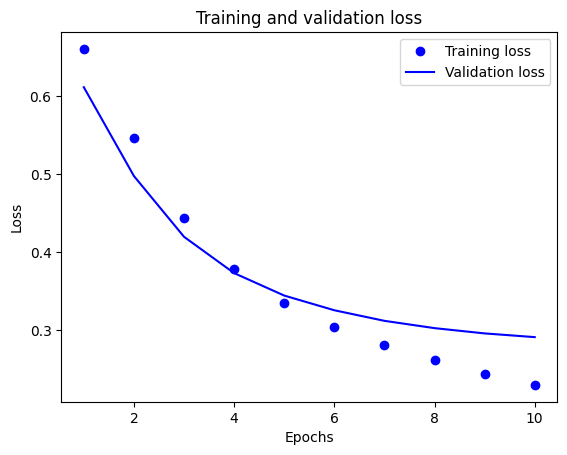

In [29]:
acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

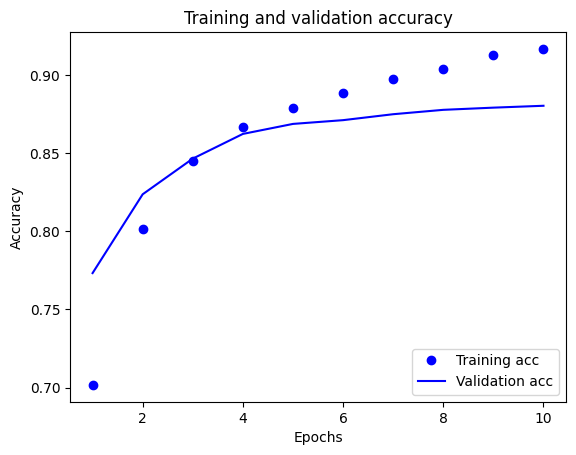

In [30]:
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

plt.show()

このグラフでは、点はトレーニングの損失と正解度を表し、実線は検証の損失と正解度を表します。

トレーニングの損失がエポックごとに*下降*し、トレーニングの正解度がエポックごとに*上昇*していることに注目してください。これは、勾配下降最適化を使用しているときに見られる現象で、イテレーションごとに希望する量を最小化します。

これは検証の損失と精度には当てはまりません。これらはトレーニング精度の前にピークに達しているようです。これが過適合の例で、モデルが、遭遇したことのないデータよりもトレーニングデータで優れたパフォーマンスを発揮する現象です。この後、モデルは過度に最適化し、テストデータに*一般化*しないトレーニングデータ*特有*の表現を学習します。

この特定のケースでは、検証の正解度が向上しなくなったときにトレーニングを停止することにより、過適合を防ぐことができます。これを行うには、`tf.keras.callbacks.EarlyStopping` コールバックを使用することができます。

## モデルをエクスポートする

上記のコードでは、モデルにテキストをフィードする前に、`TextVectorization` レイヤーをデータセットに適用しました。モデルで生の文字列を処理できるようにする場合 (たとえば、展開を簡素化するため)、モデル内に `TextVectorization` レイヤーを含めることができます。これを行うには、トレーニングしたばかりの重みを使用して新しいモデルを作成します。

In [31]:
export_model = tf.keras.Sequential([
  vectorize_layer,
  model,
  layers.Activation('sigmoid')
])

export_model.compile(
    loss=losses.BinaryCrossentropy(from_logits=False), optimizer="adam", metrics=['accuracy']
)

# Test it with `raw_test_ds`, which yields raw strings
loss, accuracy = export_model.evaluate(raw_test_ds)
print(accuracy)

  1/782 [..............................] - ETA: 4:11 - loss: 0.2929 - accuracy: 0.8438

 14/782 [..............................] - ETA: 2s - loss: 0.2773 - accuracy: 0.8929  

 28/782 [>.............................] - ETA: 2s - loss: 0.3050 - accuracy: 0.8873

 42/782 [>.............................] - ETA: 2s - loss: 0.3062 - accuracy: 0.8810

 56/782 [=>............................] - ETA: 2s - loss: 0.3059 - accuracy: 0.8806

 70/782 [=>............................] - ETA: 2s - loss: 0.3038 - accuracy: 0.8790

 85/782 [==>...........................] - ETA: 2s - loss: 0.3022 - accuracy: 0.8798

 99/782 [==>...........................] - ETA: 2s - loss: 0.3017 - accuracy: 0.8804

113/782 [===>..........................] - ETA: 2s - loss: 0.3046 - accuracy: 0.8772

128/782 [===>..........................] - ETA: 2s - loss: 0.3082 - accuracy: 0.8750

142/782 [====>.........................] - ETA: 2s - loss: 0.3047 - accuracy: 0.8768

157/782 [=====>........................] - ETA: 2s - loss: 0.3022 - accuracy: 0.8790

171/782 [=====>........................] - ETA: 2s - loss: 0.3001 - accuracy: 0.8805

185/782 [======>.......................] - ETA: 2s - loss: 0.3024 - accuracy: 0.8796

200/782 [======>.......................] - ETA: 2s - loss: 0.3027 - accuracy: 0.8797

215/782 [=======>......................] - ETA: 2s - loss: 0.3031 - accuracy: 0.8797

229/782 [=======>......................] - ETA: 2s - loss: 0.3044 - accuracy: 0.8784

244/782 [========>.....................] - ETA: 1s - loss: 0.3061 - accuracy: 0.8777

259/782 [========>.....................] - ETA: 1s - loss: 0.3056 - accuracy: 0.8772

273/782 [=========>....................] - ETA: 1s - loss: 0.3054 - accuracy: 0.8779

288/782 [==========>...................] - ETA: 1s - loss: 0.3078 - accuracy: 0.8770

302/782 [==========>...................] - ETA: 1s - loss: 0.3071 - accuracy: 0.8771

317/782 [===========>..................] - ETA: 1s - loss: 0.3086 - accuracy: 0.8756

332/782 [===========>..................] - ETA: 1s - loss: 0.3077 - accuracy: 0.8755

347/782 [============>.................] - ETA: 1s - loss: 0.3077 - accuracy: 0.8755

361/782 [============>.................] - ETA: 1s - loss: 0.3073 - accuracy: 0.8759

375/782 [=============>................] - ETA: 1s - loss: 0.3081 - accuracy: 0.8755

390/782 [=============>................] - ETA: 1s - loss: 0.3091 - accuracy: 0.8746

405/782 [==============>...............] - ETA: 1s - loss: 0.3086 - accuracy: 0.8741

420/782 [===============>..............] - ETA: 1s - loss: 0.3093 - accuracy: 0.8734

435/782 [===============>..............] - ETA: 1s - loss: 0.3095 - accuracy: 0.8732

450/782 [================>.............] - ETA: 1s - loss: 0.3087 - accuracy: 0.8739

465/782 [================>.............] - ETA: 1s - loss: 0.3096 - accuracy: 0.8739

480/782 [=================>............] - ETA: 1s - loss: 0.3100 - accuracy: 0.8738

495/782 [=================>............] - ETA: 1s - loss: 0.3099 - accuracy: 0.8735

510/782 [==================>...........] - ETA: 0s - loss: 0.3097 - accuracy: 0.8735

524/782 [===================>..........] - ETA: 0s - loss: 0.3096 - accuracy: 0.8734

539/782 [===================>..........] - ETA: 0s - loss: 0.3113 - accuracy: 0.8726

554/782 [====================>.........] - ETA: 0s - loss: 0.3122 - accuracy: 0.8721

568/782 [====================>.........] - ETA: 0s - loss: 0.3111 - accuracy: 0.8729

583/782 [=====================>........] - ETA: 0s - loss: 0.3109 - accuracy: 0.8729

597/782 [=====================>........] - ETA: 0s - loss: 0.3110 - accuracy: 0.8729

611/782 [======================>.......] - ETA: 0s - loss: 0.3110 - accuracy: 0.8726

625/782 [======================>.......] - ETA: 0s - loss: 0.3116 - accuracy: 0.8722

639/782 [=======================>......] - ETA: 0s - loss: 0.3106 - accuracy: 0.8726

654/782 [========================>.....] - ETA: 0s - loss: 0.3116 - accuracy: 0.8719

669/782 [========================>.....] - ETA: 0s - loss: 0.3118 - accuracy: 0.8717

684/782 [=========================>....] - ETA: 0s - loss: 0.3111 - accuracy: 0.8727

699/782 [=========================>....] - ETA: 0s - loss: 0.3113 - accuracy: 0.8726

714/782 [==========================>...] - ETA: 0s - loss: 0.3104 - accuracy: 0.8730

729/782 [==========================>...] - ETA: 0s - loss: 0.3113 - accuracy: 0.8728

744/782 [===========================>..] - ETA: 0s - loss: 0.3107 - accuracy: 0.8731

758/782 [============================>.] - ETA: 0s - loss: 0.3102 - accuracy: 0.8731

773/782 [============================>.] - ETA: 0s - loss: 0.3094 - accuracy: 0.8737

782/782 [==============================] - 3s 4ms/step - loss: 0.3099 - accuracy: 0.8734


0.8733999729156494


### 新しいデータの推論

新しい例の予測を取得するには、`model.predict()`を呼び出します。

In [32]:
examples = [
  "The movie was great!",
  "The movie was okay.",
  "The movie was terrible..."
]

export_model.predict(examples)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 0s 175ms/step


array([[0.61918825],
       [0.44328377],
       [0.3598296 ]], dtype=float32)

モデル内にテキスト前処理ロジックを含めると、モデルを本番環境にエクスポートして展開を簡素化し、[トレーニング/テストスキュー](https://developers.google.com/machine-learning/guides/rules-of-ml#training-serving_skew)の可能性を減らすことができます。

TextVectorization レイヤーを適用する場所を選択する際に性能の違いに留意する必要があります。モデルの外部で使用すると、GPU でトレーニングするときに非同期 CPU 処理とデータのバッファリングを行うことができます。したがって、GPU でモデルをトレーニングしている場合は、モデルの開発中に最高のパフォーマンスを得るためにこのオプションを使用し、デプロイの準備ができたらモデル内に TextVectorization レイヤーを含めるように切り替えることをお勧めします。

モデルの保存の詳細については、この[チュートリアル](https://www.tensorflow.org/tutorials/keras/save_and_load)にアクセスしてください。

## 演習：StackOverflow の質問に対するマルチクラス分類

このチュートリアルでは、IMDB データセットで二項分類器を最初からトレーニングする方法を示しました。演習として、このノートブックを変更して、[Stack Overflow](http://stackoverflow.com/) のプログラミング質問のタグを予測するマルチクラス分類器をトレーニングできます。

Stack Overflow に投稿された数千のプログラミングに関する質問（たとえば、「Python でディクショナリを値で並べ替える方法」）の本文を含む[データセット](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)が用意されています。それぞれ、1 つのタグ（Python、CSharp、JavaScript、または Java のいずれか）でラベル付けされています。この演習では、質問を入力として受け取り、適切なタグ（この場合は Python）を予測します。

使用するデータセットには、1,700 万件以上の投稿を含む [BigQuery](https://console.cloud.google.com/marketplace/details/stack-exchange/stack-overflow) の大規模な StackOverflow パブリックデータセットから抽出された数千の質問が含まれています。

データセットをダウンロードすると、以前に使用した IMDB データセットと同様のディレクトリ構造になっていることがわかります。

```
train/
...python/
......0.txt
......1.txt
...javascript/
......0.txt
......1.txt
...csharp/
......0.txt
......1.txt
...java/
......0.txt
......1.txt
```

注意: 分類問題の難易度を上げるために、プログラミングの質問での Python、CSharp、JavaScript、または Java という単語は、*blank* という単語に置き換えられました（多くの質問には、対象の言語が含まれているため）。

この演習を完了するには、、このノートブックを変更してStackOverflow データセットを操作する必要があります。次の変更を行います。

1. ノートブックの上部で、IMDB データセットをダウンロードするコードを、事前に準備されている [Stack Overflow データセット](https://storage.googleapis.com/download.tensorflow.org/data/stack_overflow_16k.tar.gz)をダウンロードするコードで更新します。Stack Overflow データセットは同様のディレクトリ構造を持っているため、多くの変更を加える必要はありません。

2. 4 つの出力クラスがあるため、モデルの最後のレイヤーを `Dense(4)` に変更します。

3. モデルをコンパイルするときは、損失を  `tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)` に変更します。これは、各クラスのラベルが整数である場合に、マルチクラス分類問題に使用する正しい損失関数です。(この場合、 0、*1*、*2*、または <em>3</em> のいずれかになります)。さらに、これはマルチクラス分類の問題であるため、メトリックを `metrics=['accuracy']` に変更します (<code>tf.metrics.BinaryAccuracy</code> はバイナリ分類器にのみ使用されます)。

4. 経時的な精度をプロットする場合は、`binary_accuracy` および `val_binary_accuracy`をそれぞれ `accuracy` および `val_accuracy` に変更します。

5. これらの変更が完了すると、マルチクラス分類器をトレーニングできるようになります。 

## 詳細

このチュートリアルでは、最初からテキスト分類を実行する方法を紹介しました。一般的なテキスト分類ワークフローの詳細については、Google Developers の[テキスト分類ガイド](https://developers.google.com/machine-learning/guides/text-classification/)をご覧ください。
